### Libraries

In [1]:
# !pip install transformers

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch, torch.nn as nn

from google.colab import drive
from torch.utils.data import Dataset, DataLoader
from transformers import BertConfig, BertModel, BertTokenizer
from IPython.display import clear_output
from sklearn.metrics import f1_score

### Data preprocessing and analysis

In [ ]:
drive.mount('/content/drive')

In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
# shuffle data a little bit
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

In [4]:
categories = {}
for n, cat in enumerate(np.unique(train_data["category"])):
  categories[cat] = n
len(categories)

77

In [5]:
def preprocess_data(data):
    data['len'] = data["text"].apply(len)
    data["lowered"] = data['text'].apply(str.lower)
    data['label'] = data['category'].apply(lambda x: categories[x])
    return data

In [6]:
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

In [7]:
train_data.head()

,text,category,len,lowered,label
0,How many transactions can I do with a disposab...,disposable_card_limits,54,how many transactions can i do with a disposab...,30
1,"I am dissatisfied, I would like to close my ac...",terminate_account,52,"i am dissatisfied, i would like to close my ac...",55
2,I am not satisfied with your service. Close m...,terminate_account,56,i am not satisfied with your service. close m...,55
3,"the balance has not changed, but I have deposi...",balance_not_updated_after_cheque_or_cash_deposit,60,"the balance has not changed, but i have deposi...",7
4,Why has my payment been declined? I paid by card.,declined_card_payment,49,why has my payment been declined? i paid by card.,26


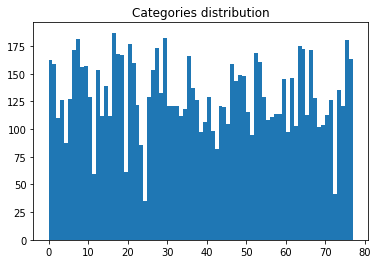

In [8]:
labels_count = np.bincount(train_data['label'])
plt.hist(train_data['label'], bins=np.arange(78))
plt.title('Categories distribution')
plt.show()

### Training process

In [9]:
class CustomTextDataset(Dataset):
    def __init__(self, texts, labels, device):
        self.texts = texts
        self.labels = labels
        self.device = device

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        text = self.texts[idx]
        sample = {"Text": text, "Label": label}
        return sample

    def get_batches(self, batch_size):

        device = self.device
        batches = []
        i = 0

        while i < len(self.texts):
            texts = self.texts[i:i+batch_size].tolist()
            labels = self.labels[i:i+batch_size].tolist()
            tokenized = tokenizer.prepare_seq2seq_batch(texts, return_tensors='pt')
            input_ids = tokenized.input_ids.to(device)
            mask = tokenized.attention_mask.to(device)
            labels = torch.LongTensor(labels).to(device)
            batch = {"input":input_ids, "mask":mask, "label":labels}
            batches.append(batch)
            i += batch_size

        return batches

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [ ]:
train_dataset = CustomTextDataset(train_data["lowered"], train_data["label"], device)
train_batches = train_dataset.get_batches(batch_size=128)

test_dataset = CustomTextDataset(test_data["lowered"], test_data["label"], device)
test_batches = test_dataset.get_batches(batch_size=128)

In [12]:
class BertForMultiLabelClassification(BertModel):
    def __init__(self, config=BertConfig(), num_labels=2):
        super(BertForMultiLabelClassification, self).__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        pooler_output = self.bert(input_ids, attention_mask, token_type_ids).pooler_output
        pooler_output = self.dropout(pooler_output)
        logits = self.classifier(pooler_output)

        if labels is not None:
            loss_func = nn.CrossEntropyLoss(weight)
            loss = loss_func(logits, labels)
            return loss
        else:
            return logits

    def freeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = False

    def unfreeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = True

In [ ]:
bert_classifier = BertForMultiLabelClassification(num_labels=77)
bert_classifier.freeze_bert_encoder()

In [14]:
torch.cuda.empty_cache()
bert_classifier.to(device)
print(device)

cuda


In [15]:
bert_classifier.load_state_dict(torch.load('/content/drive/My Drive/classifier.pt', map_location='cuda'))

<All keys matched successfully>

In [16]:
def train(model, batches, optimizer, device=device, n_epochs=1000):

    model.train()
    history = []

    for n in range(n_epochs):

        epoch_loss = 0
        for batch in batches:

            input, mask, labels = batch["input"], batch["mask"], batch["label"]

            optimizer.zero_grad()

            loss = model(input, mask, labels=labels)
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

        history.append(epoch_loss / len(batches))

        clear_output(True)
        plt.figure(figsize=(16,8))
        plt.plot(history, label='train loss')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Train loss', fontsize=12)
        plt.title('Train loss', fontsize=14)
        plt.legend()
        plt.show()

        if (n + 1) % 100 == 0:
            torch.save(model.state_dict(), '/content/drive/My Drive/classifier.pt')

    model.train(False)
    return

In [17]:
weight = torch.Tensor(labels_count / len(train_data)).to(device)

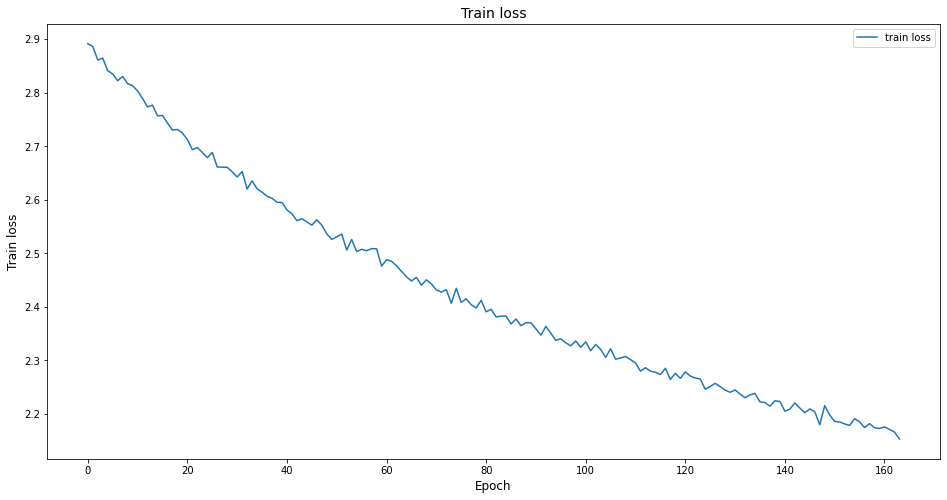

In [ ]:
optimizer = torch.optim.Adam(bert_classifier.parameters(), lr=0.0004)
train(bert_classifier, train_batches, optimizer)

In [18]:
y_pred, y_true = [], []
bert_classifier.train(False)
for batch in test_batches:
    input, mask, labels = batch["input"], batch["mask"], batch["label"]
    res = bert_classifier(input, mask)
    y_pred += res.argmax(dim=-1).cpu().tolist()
    y_true += labels.cpu().tolist()
print(f1_score(y_true, y_pred, average='micro'))

0.5911226632010397


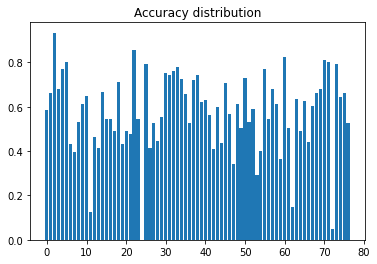

In [19]:
accuracy = f1_score(y_true, y_pred, average=None)
plt.title('Accuracy distribution')
plt.bar(np.arange(77), accuracy)
plt.show()

**Вывод:** при использовании семплинга батчей без ребалансировки классов можно заметить тенденцию, что для редких классов точность предзказания (почти) равна нулю.